# Discovering interesting model properties via generative models

We demonstrate how VAE could be used for discovering non-linear directions on the MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as scp
import skimage
import os, sys
import matplotlib.pyplot as plt
from skimage.filters import gaussian

sys.path.append(os.path.join('..'))
from scripts.data_utils_sign import *
from scripts.train_vae  import VAE, train_test_vae
from scripts.train_mnist import Net, train_test_mnist
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *

import torch
from torch import nn
import torch.utils.data
from torchvision import datasets, transforms
from torch.nn import functional as F

In [2]:
# Load data
data_root = os.path.join('..', 'data')
train_loader = torch.utils.data.DataLoader(datasets.MNIST(data_root, train=True, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST(data_root, train=False, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
# Load VAE model
PATH= '../models'
if not os.path.exists(PATH):
    os.mkdir(PATH)
if os.path.exists(os.path.join(PATH, 'vae_mnist.pt')):
    print('Loading a pre-trained model ...')
else:
    print('No pre-trained model found. Training a new one ...')
    train_test_vae(os.path.join(PATH,'vae_mnist.pt'))
vae = VAE().to('cpu')
vae.load_state_dict(torch.load(os.path.join(PATH, 'vae_mnist.pt')))
vae.eval()

Loading a pre-trained model ...


VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=10, bias=True)
  (fc22): Linear(in_features=400, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [4]:
# Load classifier
PATH= '../models'
if not os.path.exists(PATH):
    os.mkdir(PATH)
if os.path.exists(os.path.join(PATH, 'mnist_cnn.pt')):
    print('Loading a pre-trained model ...')
else:
    print('No pre-trained model found. Training a new one ...')
    train_test_mnist(os.path.join(PATH, 'mnist_cnn.pt'))
clf = Net().to('cpu')
clf.load_state_dict(torch.load(os.path.join(PATH, 'mnist_cnn.pt')))
clf.eval()

Loading a pre-trained model ...


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

(10,)


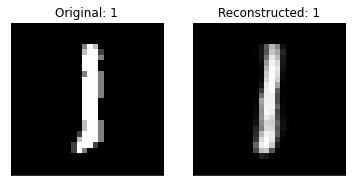

In [5]:
# Define target instance
test_idx = 14
x0, class_label = test_loader.dataset[test_idx]

# Obtain z0 from the VAE model
mu, logvar = vae.encode(x0.view(-1, 784))
z0 = vae.reparameterize(mu, logvar).detach().numpy()[0]
print(z0.shape)
latent_dim = z0.shape[-1]

# Visualize original/reconstructed image
img = vae.decode(torch.FloatTensor(z0)).reshape(1,1,28,28).detach().numpy()
probs, pred = torch.max(torch.softmax(clf(torch.FloatTensor(img)), dim=1), dim=1)

f, axes = plt.subplots(1,2)
axes[0].imshow(x0[0], cmap=matplotlib.cm.gray)
axes[1].imshow(img[0][0], cmap=matplotlib.cm.gray)
axes[0].set_xticks(())
axes[0].set_yticks(())
axes[1].set_xticks(())
axes[1].set_yticks(())
axes[0].set_title('Original: %d'%class_label)
axes[1].set_title('Reconstructed: %d'%pred);

In [6]:
# Get latent values from the training data
x_train = torch.tensor(train_loader.dataset.data, dtype=torch.float) / 255.
x_train = x_train.reshape(60000, 1, 28, 28)
mu, logvar = vae.encode(x_train.view(-1, 784))
z_train = vae.reparameterize(mu, logvar).detach().numpy()

/Users/dinouye/anaconda3/envs/adp-env-new-sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [7]:
# Make a wrapper for the classifier, using the VAE model to 
# decode latent variable z into the approximately same input xx
# in the input space for the classifier
def model(z):
    if z.ndim == 2:
        n = z.shape[0]
    else:
        n = 1
    xx = vae.decode(torch.FloatTensor(z)).reshape(n,1,28,28)
    probs = torch.softmax(clf(xx), dim=1)
    max_probs, preds = torch.max(probs, dim=1)
    probs = probs.detach().numpy()
    return probs[:, class_label]

In [8]:
# Define Utilities
mono_utility = LeastMonotonicUtility(model=model)
least_const_utility = LeastConstantUtility(model=model)
most_const_utility = MostConstantUtility(model=model)

In [9]:
# Optimize
curve_types = None
nc = 2

import time

print('optimizing for least constant utility ...')
start = time.time()
best_least_const = optimize_curve(z0, least_const_utility, z_train, max_numeric_change=nc, dtypes=None, is_image=False, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

print('optimizing for least monotonic utility ...')
start = time.time()
best_mono = optimize_curve(z0, mono_utility, z_train, max_numeric_change=nc, dtypes=None, is_image=False, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

print('optimizing for most constant utility...')
start = time.time()
best_most_const = optimize_curve(z0, most_const_utility, z_train, max_numeric_change=nc, dtypes=None, is_image=False, curve_types=curve_types)
elapsed = time.time() - start
print('-finished in %d seconds'%elapsed)

optimizing for least constant utility ...
-finished in 36 seconds
optimizing for least monotonic utility ...
-finished in 38 seconds
optimizing for most constant utility...
-finished in 36 seconds


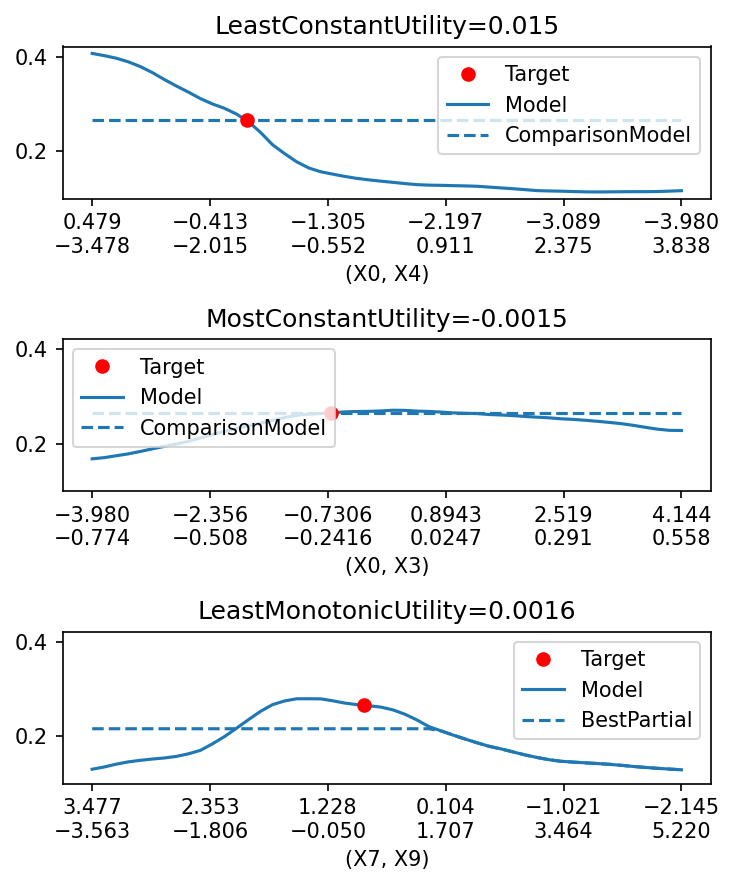

In [10]:
# Plot the curves
f, axes = plt.subplots(3, 1, figsize=(5,6), dpi=150, sharey=True)
plot_curve_vals(best_least_const, utility=least_const_utility, feature_labels=curve_types, ax=axes[0])
plot_curve_vals(best_most_const, utility=most_const_utility, feature_labels=curve_types, ax=axes[1])
plot_curve_vals(best_mono, utility=mono_utility, feature_labels=curve_types, ax=axes[2])
plt.tight_layout()
plt.savefig('curves-vae.pdf')

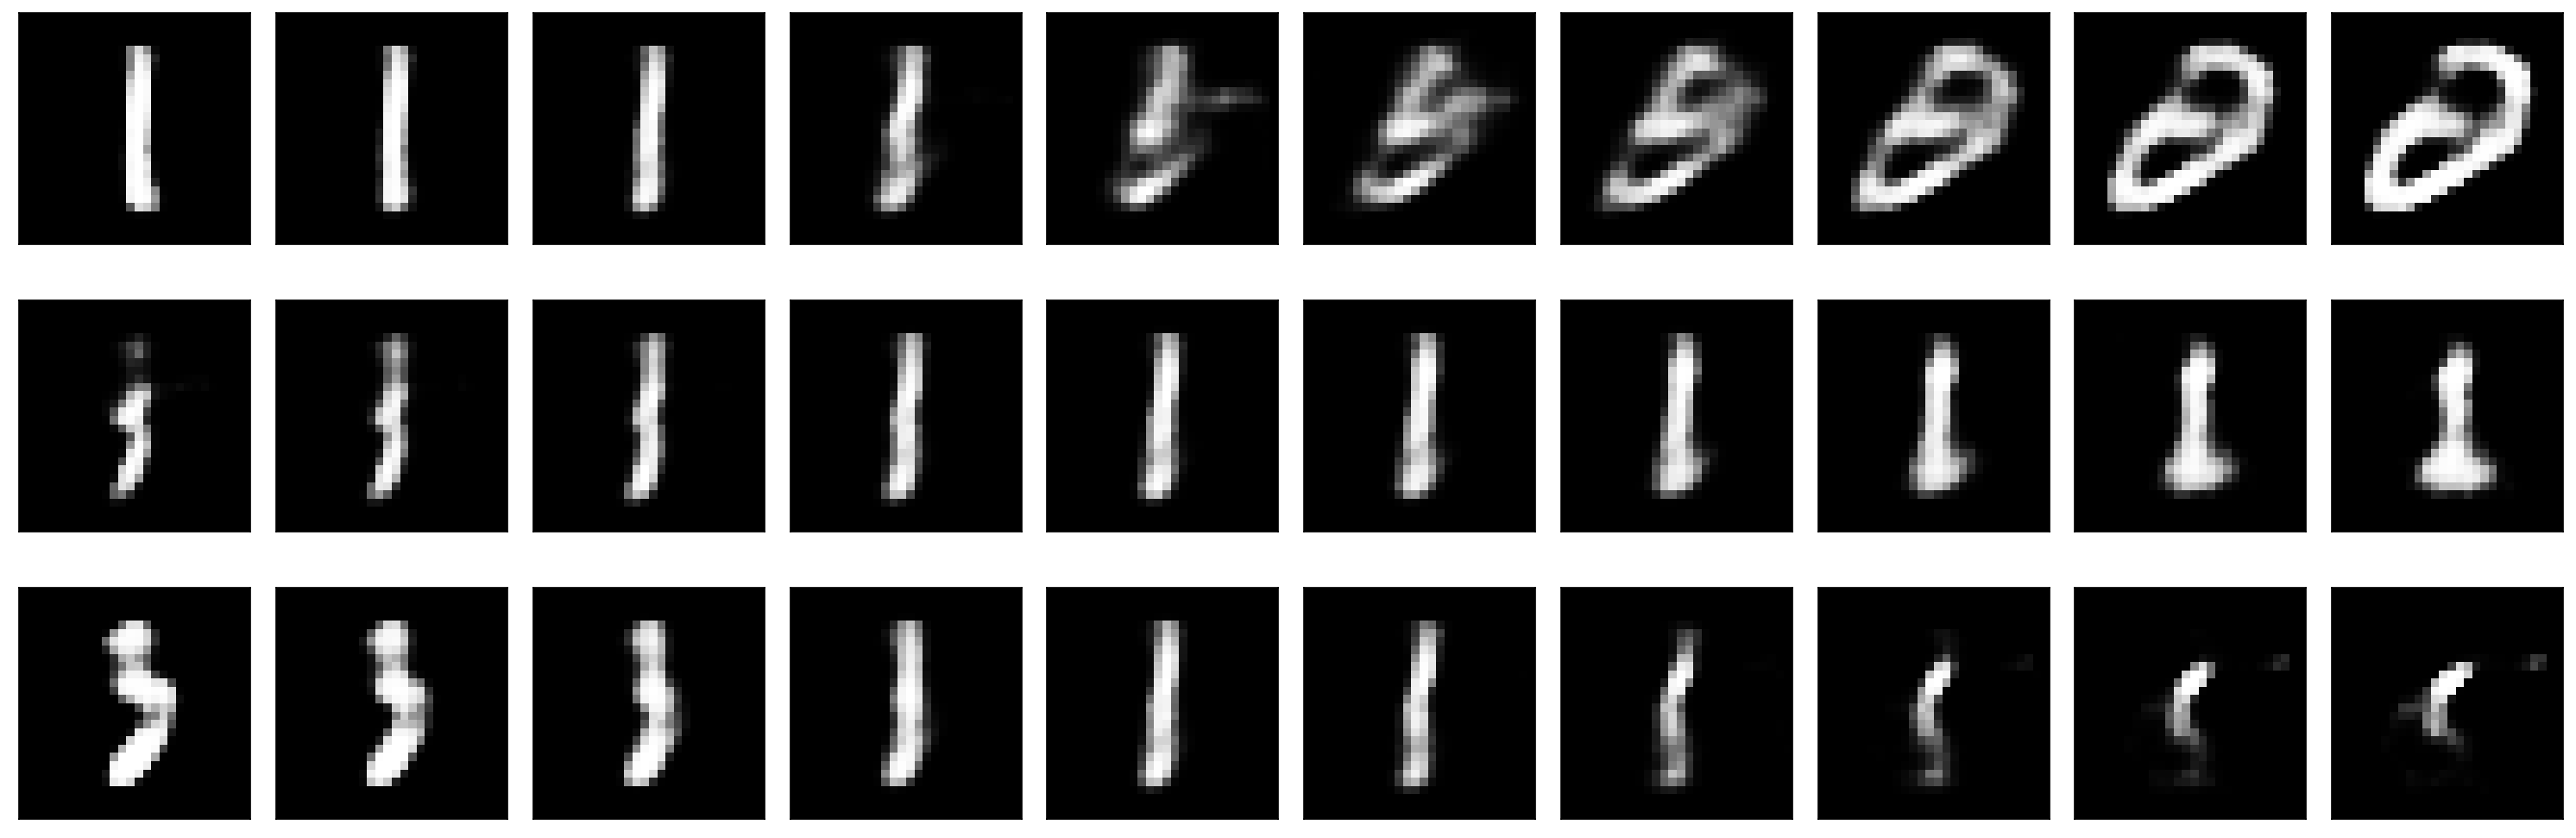

In [11]:
# Plot image changes
num_examples = 10
utils = [least_const_utility, most_const_utility, mono_utility]
curves = [best_least_const, best_most_const, best_mono]

f, axs = plt.subplots(len(curves), num_examples, figsize=(num_examples * 2, 2 * len(curves)+1), dpi=150)
for i, curve in enumerate(curves):
    idx = np.where(curve.v != 0)[0]
    t_vals = np.linspace(0, 1, num_examples)
    z_vals = curve(t_vals)
    images = vae.decode(torch.FloatTensor(z_vals)).reshape(num_examples,1,28,28).detach().numpy()
    value_title = np.outer(t_vals, curve.v)
    for j in range(images.shape[0]):
        axs[i,j].imshow(images[j][0], cmap=matplotlib.cm.gray)
        axs[i,j].set_xticks(())
        axs[i,j].set_yticks(())
        #axs[i,j].set_title('%0.3f\n%0.3f\n%0.3f'%(value_title[j, idx][0], value_title[j, idx][1], value_title[j, idx][2]), fontsize=15)
        # set title as predicted values
        #probs, pred = torch.max(torch.softmax(clf(torch.FloatTensor(images[j].reshape(1,1,28,28))), dim=1), dim=1)
        #axs[i,j].set_title('pred %d'%pred)
plt.tight_layout()
plt.savefig('imgs-vae.pdf')